# Part 1: Generate Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

dimension_count = 2
sd = 3
centers_count = 10
centers_mean = 0
centers_covariance = np.eye(dimension_count) * sd
samples_sd = 0.5

np.random.seed(8067)

centers0 = np.random.normal(loc=centers_mean, scale=sd, size=(centers_count, dimension_count))
centers1 = np.random.normal(loc=centers_mean, scale=sd, size=(centers_count, dimension_count))

In [6]:
def generate_samples():
    centers_indices = np.arange(centers_count)
    train_size = 100
    test_size = 5000
    sample_size = train_size + test_size
    samples_covariance = np.eye(dimension_count) * samples_sd
    
    selected_centers0 = np.random.choice(centers_indices, size=sample_size)
    samples0 = np.zeros((sample_size, dimension_count + 1))
    for index, center in enumerate(centers0[selected_centers0]):
        sample = np.random.multivariate_normal(mean=center, cov=samples_covariance)
        samples0[index] = np.append(sample, 0)

    selected_centers1 = np.random.choice(centers_indices, size=sample_size)
    samples1 = np.zeros((sample_size, dimension_count + 1))
    for index, center in enumerate(centers1[selected_centers0]):
        sample = np.random.multivariate_normal(mean=center, cov=samples_covariance)
        samples1[index] = np.append(sample, 1)

    train_samples = np.concatenate([samples0[:train_size], samples1[:train_size]])
    np.random.shuffle(train_samples)
    
    test_samples = np.concatenate([samples0[train_size:], samples1[train_size:]])
    np.random.shuffle(test_samples)

    return train_samples, test_samples

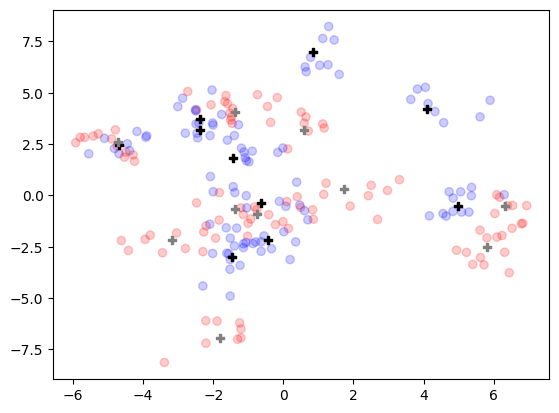

In [28]:
train_samples, test_samples = generate_samples()

colors = ["blue" if sample[2] == 0 else "red" for sample in train_samples]
labels = ["class 0" if sample[2] == 0 else "class 1" for sample in train_samples]
plt.scatter(train_samples[:, 0], train_samples[:, 1], c=colors, label=labels, alpha=0.2)

# colors = ["blue" if sample[2] == 0 else "red" for sample in test_samples]
# labels = ["class 0" if sample[2] == 0 else "class 1" for sample in test_samples]
# plt.scatter(test_samples[:, 0], test_samples[:, 1], c=colors, label=labels, alpha=0.2)

plt.scatter(centers0[:, 0], centers0[:, 1], c="black", marker="P")
plt.scatter(centers1[:, 0], centers1[:, 1], c="gray", marker="P")

# plt.legend()

# Part 2: kNN

In [31]:
from scipy.stats import mode

def kNN(train, test, k):
    # sum of squares of test and sum them (P^2)
    test_square = (test**2).sum(axis=1, keepdims=True)

    # sum of squares of train and sum them (Q^2)
    train_square = (train[:, :2]**2).sum(axis=1)

    # Train and Test(complement) multiplication, to be (P*Q.T)
    test_dot_train = test[:,:2].dot(train[:, :2].T)

    # Vectorized Fomula for Computing Distances (P^2 + Q^2 - 2*P*Q)
    dists = np.sqrt(test_square + train_square - 2 * test_dot_train)

    # argsort to sort distances individually
    sorted_indices = np.argsort(dists, axis=1)

    # Get the k smallest distances
    k_smallest_indices = sorted_indices[:, :k]

    # Get the labels of those distances
    k_nearest_labels = train[k_smallest_indices, 2]

    # Compute the mode of the labels (for classification)
    modes, counts = mode(k_nearest_labels, axis=1)

    # If there's a tie, choose the label of the nearest neighbor
    tie_indices = np.where(counts == k / 2)
    modes[tie_indices] = train[k_smallest_indices[tie_indices, 0], 2]

    return modes.ravel()

## Implementation

#### Distances Ties

From Numpy documentation for `argsort`:

When a is an array with fields defined, this argument specifies which fields to compare first, second, etc. A single field can be specified as a string, and not all fields need be specified, but unspecified fields will still be used, in the order in which they come up in the dtype, to break ties.

So precedent is given to training entry with lower index, which is random since we shuffled the dataset.

#### Voting Ties

If equal number of votes, then precedent is given to the `0` class

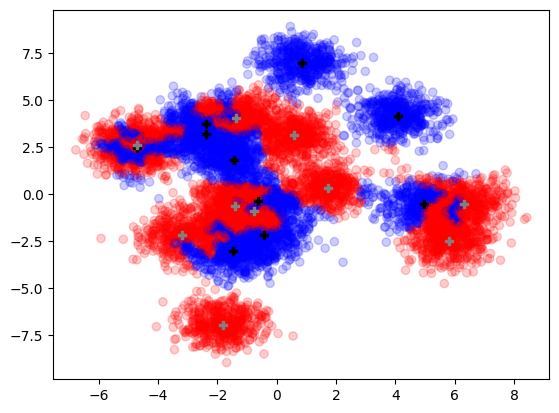

In [14]:
predictions = kNN(train_samples, test_samples, 1)

colors = ["red" if prediction else "blue" for prediction in predictions]
plt.scatter(test_samples[:, 0], test_samples[:, 1], alpha=0.2, c=colors)

plt.scatter(centers0[:, 0], centers0[:, 1], c="black", marker="P")
plt.scatter(centers1[:, 0], centers1[:, 1], c="gray", marker="P")

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [32]:
print("1-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 1)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

print("3-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 3)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

print("5-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 5)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

1-NN Confusion Matrices (top is own implementation, bottom is sklearn)


C:\Users\Jacob\AppData\Local\Temp\ipykernel_14196\3204817254.py:26: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  modes, counts = mode(k_nearest_labels, axis=1)


[[3996 1004]
 [1089 3911]]
[[3996 1004]
 [1089 3911]]
3-NN Confusion Matrices (top is own implementation, bottom is sklearn)


C:\Users\Jacob\AppData\Local\Temp\ipykernel_14196\3204817254.py:26: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  modes, counts = mode(k_nearest_labels, axis=1)


[[3921 1079]
 [ 953 4047]]
[[3921 1079]
 [ 953 4047]]
5-NN Confusion Matrices (top is own implementation, bottom is sklearn)


C:\Users\Jacob\AppData\Local\Temp\ipykernel_14196\3204817254.py:26: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  modes, counts = mode(k_nearest_labels, axis=1)


[[3965 1035]
 [ 989 4011]]
[[3965 1035]
 [ 989 4011]]


# Part 3: cvKNN

In [23]:
import sys

def cv_knn(train_samples, fold_count):
    n = train_samples.shape[0]
    fold_count = 10
    fold_size = n // fold_count
    
    min_error = sys.maxsize
    best_k = -1
    for k in range(1, n - fold_size + 1):
    
        average_error = 0
        
        for i in range(fold_count):
            start = i * fold_size
            end = (i + 1) * fold_size
            
            holdout = train_samples[start:end]
            train_data = np.concatenate([train_samples[end:], train_samples[:start]])
        
            neigh = KNeighborsClassifier(n_neighbors=k)
            neigh.fit(train_data[:, :2], train_data[:, 2])
            predictions_sklearn = neigh.predict(holdout[:, :2])
        
            matrix = confusion_matrix(holdout[:, 2], predictions_sklearn)
            error = (matrix[0, 1] + matrix[1, 0]) / holdout.shape[0]
            average_error = ((average_error * i) + error) / (i + 1)
        
        if average_error <= min_error:
            min_error = average_error
            best_k = k

    return best_k

# Part 4: Bayes Rule

In [10]:
def bayes_prob_predictions(centers0, centers1, test_samples, sd):
    class0_probs = np.zeros((test_samples.shape[0]))
    for center in centers0:
        distance = -np.linalg.norm(test_samples[:, :2] - center, axis=1)**2
        class0_probs += np.exp(distance / (2 * samples_sd**2))
    
    class1_probs = np.zeros((test_samples.shape[0]))
    for center in centers1:
        distance = -np.linalg.norm(test_samples[:, :2] - center, axis=1)**2
        class1_probs += np.exp(distance / (2 * samples_sd**2))

    bayes_prob = class0_probs / class1_probs
    return np.where(bayes_prob > 1, 0, 1)

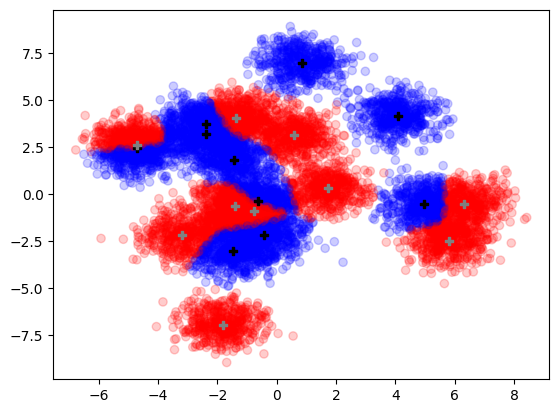

In [11]:
bayes_predictions = bayes_prob_predictions(centers0, centers1, test_samples, centers_covariance)

colors = ["red" if prediction else "blue" for prediction in bayes_predictions]
plt.scatter(test_samples[:, 0], test_samples[:, 1], alpha=0.2, c=colors)

plt.scatter(centers0[:, 0], centers0[:, 1], c="black", marker="P")
plt.scatter(centers1[:, 0], centers1[:, 1], c="gray", marker="P")

In [269]:
nib = centers1[0] - test_samples[:, :2]
print(nib.shape)

(10000, 2)


# Part 5: Simulation Study

In [27]:
num_simulations = 50

n = test_samples.shape[0]

knn_errors = np.zeros(num_simulations)
cvknn_errors = np.zeros(num_simulations)
bayes_errors = np.zeros(num_simulations)

for i in range(num_simulations):
    if i % 5 == 0:
        print("Iteration No.", i)
    
    new_train_samples, new_test_samples = generate_samples()
    test_labels = new_test_samples[:, 2]
    
    knn_predictions = kNN(new_train_samples, new_test_samples, 7)
    correct_predictions = np.sum(np.equal(test_labels, knn_predictions))
    knn_errors[i] = 1 - (correct_predictions / n)

    cv_knn_best_k = cv_knn(new_train_samples, 10)
    cvknn_predictions = kNN(new_train_samples, new_test_samples, cv_knn_best_k)
    correct_predictions = np.sum(np.equal(test_labels, cvknn_predictions))
    cvknn_errors[i] = 1 - (correct_predictions / n)

    bayes_predictions = bayes_prob_predictions(centers0, centers1, new_test_samples, centers_covariance)
    correct_predictions = np.sum(np.equal(test_labels, bayes_predictions))
    bayes_errors[i] = 1 - (correct_predictions / n)

Iteration No. 0
8
6
14
8
3
Iteration No. 5
7
15
5
10
11
Iteration No. 10
6
14
8
11


KeyboardInterrupt: 

In [25]:
def print_summary_statistics(model_name, min, max, first_q, second_q, third_q):
    print("#############")
    print(model_name, "Error Rate Summary Statistics")
    print("#############")
    print("Min: ", min)
    print("Max: ", max)
    print("25% Quantile: ", first_q)
    print("50% Quantile: ", second_q)
    print("75% Quantile: ", third_q)

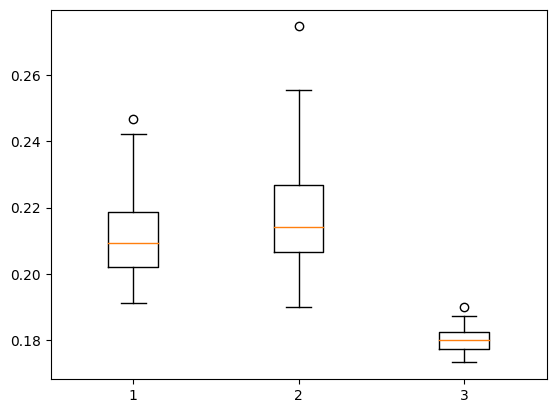

#############
7-NN Error Rate Summary Statistics
#############
Min:  0.19110000000000005
Max:  0.24660000000000004
25% Quantile:  0.201975
50% Quantile:  0.20930000000000004
75% Quantile:  0.21872499999999997
#############
5-NN (chosen by CV) Error Rate Summary Statistics
#############
Min:  0.18989999999999996
Max:  0.27459999999999996
25% Quantile:  0.20657500000000004
50% Quantile:  0.21404999999999996
75% Quantile:  0.22690000000000002
#############
Bayes Rule Error Rate Summary Statistics
#############
Min:  0.1733
Max:  0.18989999999999996
25% Quantile:  0.177475
50% Quantile:  0.18010000000000004
75% Quantile:  0.1824


In [26]:
plt.boxplot([knn_errors, cvknn_errors, bayes_errors])
plt.show()

print_summary_statistics("7-NN", np.min(knn_errors), np.max(knn_errors), 
                         np.quantile(knn_errors, 0.25), np.quantile(knn_errors, 0.5), 
                         np.quantile(knn_errors, 0.75))
print_summary_statistics("5-NN (chosen by CV)", np.min(cvknn_errors), np.max(cvknn_errors), 
                         np.quantile(cvknn_errors, 0.25), np.quantile(cvknn_errors, 0.5), 
                         np.quantile(cvknn_errors, 0.75))
print_summary_statistics("Bayes Rule", np.min(bayes_errors), np.max(bayes_errors), 
                         np.quantile(bayes_errors, 0.25), np.quantile(bayes_errors, 0.5), 
                         np.quantile(bayes_errors, 0.75))